In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v3'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '2024_0827_180109'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Dataset length: 6019


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            model.metrics.update(pred,batch)
            # pred['mid_output']['sampled_feats'].retain_grad()
            # loss = model.loss_func(pred,batch)
            # loss[0].backward()
            # vis_result = viz(batch,pred)
    # if i ==5:
            break   
        
if CHECKPOINT_PATH is None:
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is None:
            print(name)
# model.metrics.update(pred,batch)


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
model.metrics.compute()

{'IoU_VEHICLE': tensor(0.3902, device='cuda:0')}

In [ ]:
pred['mid_output']['inter_output'][0]
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
feat = pred['mid_output']['inter_output'][1][0].reshape(128, 200, 200).permute(1,2,0).view(-1, 128).sigmoid().detach().numpy()
# feat = pca.fit_transform(feat).reshape(200,200,128)
feat = feat.reshape(200,200,128)
row, column = 1, 4
fig, ax = plt.subplots(row, column, figsize=(10, 4))
for i in range(column):
    ax[i].imshow(feat[:,:,i+12])

Text(0.5, 1.0, 'Prediction')

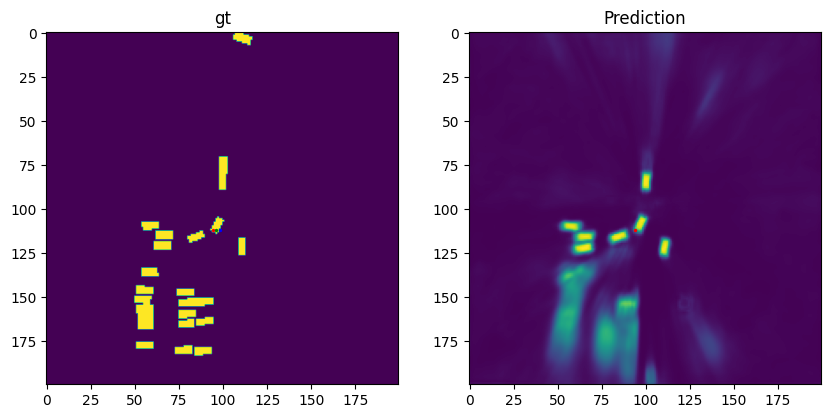

In [9]:
batch_index = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
y = 112
x = 94
vehicle_idx = [[4,5,6,7,8,10,11]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
ax1.imshow(vehicles[batch_index,0].detach().cpu().numpy())
ax1.scatter([x],[y], s=2, c='r')
ax1.scatter([x+2],[y], s=2, c='g')
ax1.scatter([x+4],[y], s=2, c='b')
ax1.set_title('gt')

ax2.imshow(((pred['VEHICLE'][batch_index,0].sigmoid().detach().cpu())).numpy())
ax2.scatter([x],[y], s=2, c='r')
ax2.set_title('Prediction')
# plt.title('2D')

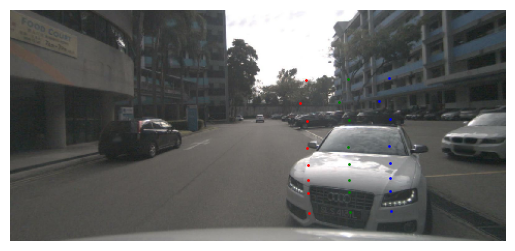

In [4]:
# mean height supervised
# x = [[[0.7693, 0.5553]],

#         [[0.7684, 0.5310]],

#         [[0.7685, 0.5168]],

#         [[0.7683, 0.4997]],

#         [[0.7683, 0.4792]],

#         [[0.7686, 0.4479]],

#         [[0.7634, 0.4275]],

#         [[0.7679, 0.4024]]]

# y = [[[0.7473, 0.5565]],

#         [[0.7465, 0.5323]],

#         [[0.7466, 0.5182]],

#         [[0.7464, 0.5010]],

#         [[0.7463, 0.4806]],

#         [[0.7467, 0.4494]],

#         [[0.7417, 0.4290]],

#         [[0.7460, 0.4040]]]

# z = [[[0.7254, 0.5597]],

#         [[0.7246, 0.5356]],

#         [[0.7247, 0.5219]],

#         [[0.7244, 0.5047]],

#         [[0.7244, 0.4842]],

#         [[0.7248, 0.4530]],

#         [[0.7195, 0.4330]],

#         [[0.7241, 0.4074]]]
x = [[[0.7680, 0.8677]],

        [[0.7653, 0.7809]],

        [[0.7657, 0.7265]],

        [[0.7641, 0.6602]],

        [[0.7638, 0.5873]],

        [[0.7655, 0.4686]],

        [[0.7427, 0.3912]],

        [[0.7627, 0.2928]]]
y= [[[0.6847, 0.8737]],

        [[0.6823, 0.7868]],

        [[0.6829, 0.7325]],

        [[0.6815, 0.6664]],

        [[0.6807, 0.5935]],

        [[0.6819, 0.4747]],

        [[0.6626, 0.3968]],

        [[0.6795, 0.2981]]]

z= [[[0.6013, 0.8774]],

        [[0.5993, 0.7904]],

        [[0.5999, 0.7361]],

        [[0.5988, 0.6701]],

        [[0.5974, 0.5971]],

        [[0.5982, 0.4784]],

        [[0.5830, 0.4001]],

        [[0.5961, 0.3013]]]

x = np.array(x)[:,0]
x[:, 0] *= 480
x[:, 1] *= 224

y = np.array(y)[:,0]
y[:, 0] *= 480
y[:, 1] *= 224

z = np.array(z)[:,0]
z[:, 0] *= 480
z[:, 1] *= 224

plt.imshow(batch['image'][0,4].cpu().permute(1,2,0))
plt.scatter(x[:,0],x[:,1],s=1, c='b')
plt.scatter(y[:,0],y[:,1],s=1, c='g')
plt.scatter(z[:,0],z[:,1],s=1, c='r')
plt.axis('off')
plt.show()

In [ ]:
plt.imshow(vis_result[0])

In [ ]:
from nuscenes.nuscenes import NuScenes

# Load the nuScenes dataset (mini-split, in this case).
nusc = NuScenes(version='v1.0-trainval', dataroot='/media/hcis-s20/SRL/nuscenes/trainval/', verbose=False)

In [ ]:
for batch in loader:
    break
nusc.render_sample(batch['token'][0])

In [ ]:
# viz.label_indices = [4, 5, 6, 7,8,9,10,11]
# from cross_view_transformer.visualizations.common import get_colors
# SEMANTICS = [viz.SEMANTICS[i] for i in viz.label_indices]
# viz.colors = get_colors(SEMANTICS)
for batch in loader:
    break
plt.imshow(viz.visualize_bev(batch['bev'][0], batch['view'][0].numpy()))
# plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
plt.axis('off')

In [ ]:
plt.imshow(viz(batch)[0])

In [ ]:
a = torch.rand((4, 40000, 1, 8, 128))
a = a.reshape(4 *40000,8, 128)
attention = nn.MultiheadAttention(128, 4, batch_first=True)
attention(a, a, a)

In [ ]:
batch = dataset.__getitem__(4004)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v[None]
# with torch.no_grad():
#     pred = network(batch)
pred = None
vis_result = viz(batch, pred)
plt.imshow(vis_result[0])

In [ ]:
plt.imshow(pred['VEHICLE'][0,0].sigmoid())

In [ ]:
a = np.random.rand((5))
print(a)

In [ ]:
(a > 0.6).all()

In [ ]:
for i,batch in enumerate(loader):
    break
img = batch['bev']
print(img.shape)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
vehicle_idx = [[4,5,6,7,8,10,11]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
ax1.imshow(vehicles[0,0])
vehicles = F.interpolate(vehicles, size=[25,25], mode='bilinear')
ax2.imshow(vehicles[0,0])

In [ ]:
vehicles = F.interpolate(vehicles, size=[200,200], mode='bilinear')
plt.imshow(vehicles[0,0])

In [ ]:
import torch.nn as nn
import torch
camera = nn.Embedding(6, 128)
camera(torch.tensor([0,1,2])).shape